# 데이터 설명

https://www.dacon.io/competitions/official/235713/overview/description/

### train 데이터 : 신용카드 사용자들의 개인 신상정보

- credit 열 포함

- train.shape : (26457, 20)

###  test 데이터 : 신용카드 사용자들의 개인 신상정보

- credit 열 미포함

- test.shape : (10000, 19)

### 변수 설명 credit 열 미포함

- test.shape : (10000, 19)

 credit 열 미포함

- test.shape : (10000, 19)

### 변수 설명

- index
- gender: 성별
- car: 차량 소유 여부
- reality: 부동산 소유 여부
- child_num: 자녀 수
- income_total: 연간 소득
- income_type: 소득 분류
							['Commercial associate', 'Working', 'State servant', 'Pensioner', 'Student']
- edu_type: 교육 수준
							['Higher education' ,'Secondary / secondary special', 'Incomplete higher', 'Lower secondary', 'Academic degree']
- family_type: 결혼 여부
							['Married', 'Civil marriage', 'Separated', 'Single / not married', 'Widow']
- house_type: 생활 방식
							['Municipal apartment', 'House / apartment', 'With parents',
							 'Co-op apartment', 'Rented apartment', 'Office apartment']
- DAYS_BIRTH: 출생일
							데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전에 태어났음을 의미
- DAYS_EMPLOYED: 업무 시작일
							데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 하루 전부터 일을 시작함을 의미, 양수 값은 고용되지 않은 상태를 의미함
- FLAG_MOBIL: 핸드폰 소유 여부
- work_phone: 업무용 전화 소유 여부
- phone: 전화 소유 여부
- email: 이메일 소유 여부
- occyp_type: 직업 유형													
- family_size: 가족 규모
- begin_month: 신용카드 발급 월
							데이터 수집 당시 (0)부터 역으로 셈, 즉, -1은 데이터 수집일 한 달 전에 신용카드를 발급함을 의미
- credit: 사용자의 신용카드 대금 연체를 기준의 신용도
							=> 낮을 수록 높은 신용의 신용카드 사용자를 의미함

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')
%matplotlib inline

In [ ]:
paths = '/content/drive/MyDrive/DataAnalysis/신용카드 사용자 연체 예측 AI 경진대회/input/'

train = pd.read_csv(paths + 'train.csv')
test = pd.read_csv(paths + 'test.csv')
submission = pd.read_csv(paths + 'sample_submission.csv')

In [ ]:
def get_occyp_type(x):
  if pd.isnull(x['occyp_type']):
    if x['DAYS_EMPLOYED'] >= 0: return 'No job'
    else: return 'others'
  return x['occyp_type']

train['occyp_type'] = train.apply(lambda x : get_occyp_type(x), axis=1)
test['occyp_type'] = test.apply(lambda x : get_occyp_type(x), axis=1)

In [ ]:
train['DAYS_BIRTH'] = train['DAYS_BIRTH'].apply(lambda x : abs(x))
test['DAYS_BIRTH'] = test['DAYS_BIRTH'].apply(lambda x : abs(x))

train['m_DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].apply(lambda x : abs(x) if x < 0 else 0)
test['m_DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].apply(lambda x : abs(x) if x < 0 else 0)
train['p_DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].apply(lambda x : abs(x) if x > 0 else 0)
test['p_DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].apply(lambda x : abs(x) if x > 0 else 0)

train['begin_month'] = train['begin_month'].apply(lambda x : abs(x))
test['begin_month'] = test['begin_month'].apply(lambda x : abs(x))

In [ ]:
def get_IEp(x):
  ret = 0
  if x['m_DAYS_EMPLOYED'] > 0 :
    ret = x['income_total'] / x['m_DAYS_EMPLOYED']
    return ret
  return ret

train['IEp'] = train.apply(lambda x : get_IEp(x), axis=1)
test['IEp'] = test.apply(lambda x : get_IEp(x), axis=1)

In [ ]:
def get_IBp(x):
  ret = x['income_total'] / x['DAYS_BIRTH']
  return ret

train['IBp'] = train.apply(lambda x : get_IBp(x), axis=1)
test['IBp'] = test.apply(lambda x : get_IBp(x), axis=1)

In [ ]:
def get_EBp(x):
  ret = x['m_DAYS_EMPLOYED'] / x['DAYS_BIRTH']
  return ret
  
train['EBp'] = train.apply(lambda x : get_EBp(x), axis=1)
test['EBp'] = test.apply(lambda x : get_EBp(x), axis=1)

In [ ]:
def get_staff(x):
  if 'staff' in x:
    return 1
  return 0

train['staff'] = train['occyp_type'].apply(lambda x: get_staff(x))
test['staff'] = test['occyp_type'].apply(lambda x: get_staff(x))

In [ ]:
# LabelEncoder
from sklearn.preprocessing import LabelEncoder
# 속도 체크
from tqdm import tqdm_notebook

# 원본데이터의 변형을 막고자 데이터를 copy함
temp_train = train.copy()
temp_test = test.copy()

lbl = LabelEncoder()

cat_columns = [c for c, t in zip(test.dtypes.index, test.dtypes) if t == 'O']
# cat_columns = [i for i in cat_columns if i != 'occyp_type']
# Implement Label Encoding 
for col in tqdm_notebook( cat_columns ):
    # local_train과 local_test를 concat하여 temp_df에 저장
    temp_df = pd.concat([ temp_train[[col]], temp_test[[col]] ] , axis=0)
    
    # Label-Encoding을 fitting함
    lbl.fit( temp_df[col] )
    
    # local_train/local_test에 label_encoding한 값을 대입함
    temp_train[col] = lbl.transform(temp_train[col])
    temp_test[col] = lbl.transform(temp_test[col])

target = 'credit'
features = [i for i in train.columns if i != 'credit']

X_train = temp_train[features]
y_train = temp_train[target]

X_test = temp_test[features]

In [ ]:
# features = ['income_total', 'income_type','edu_type', 'family_type', 'DAYS_BIRTH', 
#  'DAYS_EMPLOYED', 'occyp_type', 'family_size', 'begin_month', 'year_BIRTH', 
#  'month_BIRTH', 'month_EMPLOYED', 'BBp', 'BEp', 'IBpm', 'IEpm', 'IBpy','IEpy']

X_train = X_train.drop(labels = 'index', axis=1)
X_test = X_test.drop(labels = 'index', axis=1)

In [ ]:
X_train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,m_DAYS_EMPLOYED,p_DAYS_EMPLOYED,IEp,IBp,EBp,staff
0,0,0,0,0,202500.0,0,1,1,2,13899,-4709,1,0,0,0,19,2.0,6.0,4709,0,43.002761,14.569393,0.338801,0
1,0,0,1,1,247500.0,0,4,0,1,11380,-1540,1,0,0,1,8,3.0,5.0,1540,0,160.714286,21.748682,0.135325,0
2,1,1,1,0,450000.0,4,1,1,1,19087,-4434,1,0,1,0,10,2.0,22.0,4434,0,101.488498,23.576256,0.232305,0
3,0,0,1,0,202500.0,0,4,1,1,15088,-2092,1,0,1,0,15,2.0,37.0,2092,0,96.797323,13.421262,0.138653,1
4,0,1,1,0,157500.0,2,1,1,1,15037,-2105,1,0,0,0,10,2.0,26.0,2105,0,74.821853,10.474164,0.139988,0


# 베이지안 파라미터 튜닝

In [ ]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp37-none-any.whl size=11687 sha256=a88568f617415c13e300f3c1df115d8c5daad9b50170c1d3253048b9a7459ade
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [ ]:
from sklearn.metrics import log_loss, make_scorer
from sklearn.model_selection import cross_validate
from bayes_opt import BayesianOptimization
from sklearn.model_selection import StratifiedKFold
import lightgbm as LGBM

n_split = 5

def lgbm_cv(learning_rate, num_leaves, max_depth, min_child_weight, colsample_bytree, subsample):
  model = LGBM.LGBMClassifier(
                              random_state = 22,
                              tree_method = 'gpu_hist',
                              predictor = 'gpu_predictor',
                              n_estimators = 1000,
                              learning_rate = learning_rate,
                              num_leaves = int(round(num_leaves)),
                              max_depth = int(round(max_depth)),
                              min_child_weight = min_child_weight,
                              colsample_bytree = colsample_bytree,
                              subsample = subsample
                              )
  cv = StratifiedKFold(n_splits = n_split, shuffle=True, random_state = 22)
  result = cross_validate(model, X_train, y_train, cv = cv, scoring='neg_log_loss')
  result = result['test_score'].mean()
  return result

# param = {
#     'random_state' : 22,
#     'tree_method' : 'gpu_hist',
#     'predictor' : 'gpu_predictor',
#     'n_estimators' : 2000,
#     'max_depth' : -1,
#     # 'subsample' : np.random.uniform(low=0.5, high=1),
#     # 'colsample_bytree' : np.random.uniform(low=0.5, high=1),
#     # 'learning_rate' : random.choice([0.1, 0.09, 0.08, 0.07, 0.06, 0.05]),
#     'subsample' : 0.7,
#     'colsample_bytree' : 0.7,
#     'learning_rate' :  0.05,
#     'boosting_type' : 'gbdt',
#     'metric' : 'multiclass'
# }

pbounds = {'learning_rate' : (0.009, 0.01),
           'num_leaves': (250, 330),
           'max_depth': (100, 200),
           'min_child_weight': (0.001, 5),
           'colsample_bytree': (0.25, 0.35),
           'subsample': (0.1, 0.4)
          }

lgbmBO = BayesianOptimization(f = lgbm_cv, pbounds = pbounds, verbose = 2, random_state = 22)
lgbmBO.maximize(init_points=10, n_iter = 50, acq='ei', xi=0.01)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------------------------------
|  1        | -0.7039   |  0.2708   |  0.009482 |  142.1    |  4.296    |  263.7    |  0.2017   |
|  2        | -0.7037   |  0.2771   |  0.009691 |  122.0    |  4.06     |  250.8    |  0.2684   |
|  3        | -0.7055   |  0.3314   |  0.009745 |  118.9    |  0.0317   |  311.8    |  0.3873   |
|  4        | -0.7033   |  0.3202   |  0.009298 |  176.8    |  3.441    |  281.0    |  0.2846   |
|  5        | -0.7057   |  0.2928   |  0.009584 |  170.3    |  0.5604   |  323.9    |  0.3967   |
|  6        | -0.706    |  0.3177   |  0.009795 |  102.9    |  0.8896   |  320.0    |  0.3235   |
|  7        | -0.7039   |  0.3008   |  0.009128 |  148.4    |  2.579    |  274.9    |  0.1137   |
|  8        | -0.7049   |  0.2938   |  0.009096 |  104.5    |  3.424    |  317.9    |  0.1376   |
|  9        | -0.704

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | num_le... | subsample |
---------------------------------------------------------

|  2        | -0.7194   |  0.4867   |  0.06914  |  25.16    |  8.12     |  22.15    |  0.6872   |


|  20       | -0.7106   |  0.5989   |  0.003477 |  99.93    |  2.728    |  599.5    |  0.6563   |

|  24       | -0.7035   |  0.3      |  0.009988 |  100.0    |  0.001    |  258.3    |  0.3      |

|  7        | -0.7071   |  0.3032   |  0.01078  |  196.9    |  5.158    |  324.5    |  0.1183   |

|  8        | -0.7112   |  0.2751   |  0.009315 |  109.0    |  6.848    |  539.7    |  0.1501   |

|  18       | -0.7026   |  0.323    |  0.009283 |  199.5    |  0.2399   |  250.9    |  0.2383   |

|  16       | -0.7031   |  0.3495   |  0.009457 |  199.9    |  2.41     |  250.4    |  0.3816   |

| 4 | -0.7033 | 0.3202 | 0.009298 | 176.8 | 3.441 | 281.0 | 0.2846 |

|  28       | -0.7028   |  0.3181   |  0.00969  |  199.4    |  1.311    |  250.2    |  0.2315   |

|  27       | -0.7038   |  0.2713   |  0.009476 |  101.1    |  4.777    |  250.3    |  0.1318   |

|  28       | -0.7028   |  0.3181   |  0.00969  |  199.4    |  1.311    |  250.2    |  0.2315   |

|  29       | -0.7028   |  0.331    |  0.00966  |  100.8    |  1.128    |  250.4    |  0.3803   |


# 예측

In [ ]:
# 데이터 분할
from sklearn.model_selection import StratifiedKFold

# 모델
import lightgbm as LGBM

# 속도 체크
from tqdm import tqdm_notebook

# CV는 20로
n_split = 10

# 균등하게 니눌때 사용
skf = StratifiedKFold(n_splits = n_split, shuffle=True, random_state=22)

# train 데이터에 대한 예측 값이 저장될 배열
lgbm_oof_train = np.zeros((y_train.shape[0], 3))

# test 데이터에 대한 예측 값이 저장될 배열
lgbm_oof_test = np.zeros((X_test.shape[0], 3))

param = {
    'random_state' : 22,
    'tree_method' : 'gpu_hist',
    'predictor' : 'gpu_predictor',
    'max_depth' : 100,
    'subsample' : 0.3,
    'colsample_bytree' : 0.3,
    'learning_rate' : 0.009988,
    'n_estimators' : 2000,
    'min_child_weight' : 0.001,
    'num_leaves' : 258
}

lgbm = LGBM.LGBMClassifier(**param)

# oof 방식을 통한 예측
for trn_idx, val_idx in tqdm_notebook(skf.split(X_train, y_train)):
  trn_data, trn_label = X_train.iloc[trn_idx], y_train.iloc[trn_idx]
  val_data, val_label = X_train.iloc[val_idx], y_train.iloc[val_idx]

  # LGBM
  lgbm.fit(trn_data, trn_label, eval_set=(val_data, val_label), early_stopping_rounds = 100, verbose=0)
  lgbm_valid_pred = lgbm.predict_proba(val_data)
  lgbm_oof_train[val_idx] = lgbm_valid_pred

  lgbm_test_pred = lgbm.predict_proba(X_test)
  lgbm_oof_test += lgbm_test_pred / n_split

In [ ]:
from sklearn.metrics import log_loss

print("LGBMClassifier         :{} ".format( log_loss(y_train, lgbm_oof_train) ))

LGBMClassifier         :0.6886720769846356 


In [ ]:
PATH = '/content/drive/MyDrive/DataAnalysis/신용카드 사용자 연체 예측 AI 경진대회/output/'

submission.iloc[:, 1:] = lgbm_oof_test
submission.to_csv(PATH + '20210423_LGBM_cv20.csv', index=False)
submission.head()

,index,0,1,2
0,26457,0.084337,0.097750,0.817913
1,26458,0.303054,0.262711,0.434235
2,26459,0.021173,0.043047,0.935780
3,26460,0.093202,0.104168,0.802630
4,26461,0.071534,0.173334,0.755133


LGBMRegressor         :0.7057181451888594 <- cv20


LGBMRegressor         :0.7069431176226842 <- cv100

[Text(0.5, 1.0, 'Coef of LGBM')]

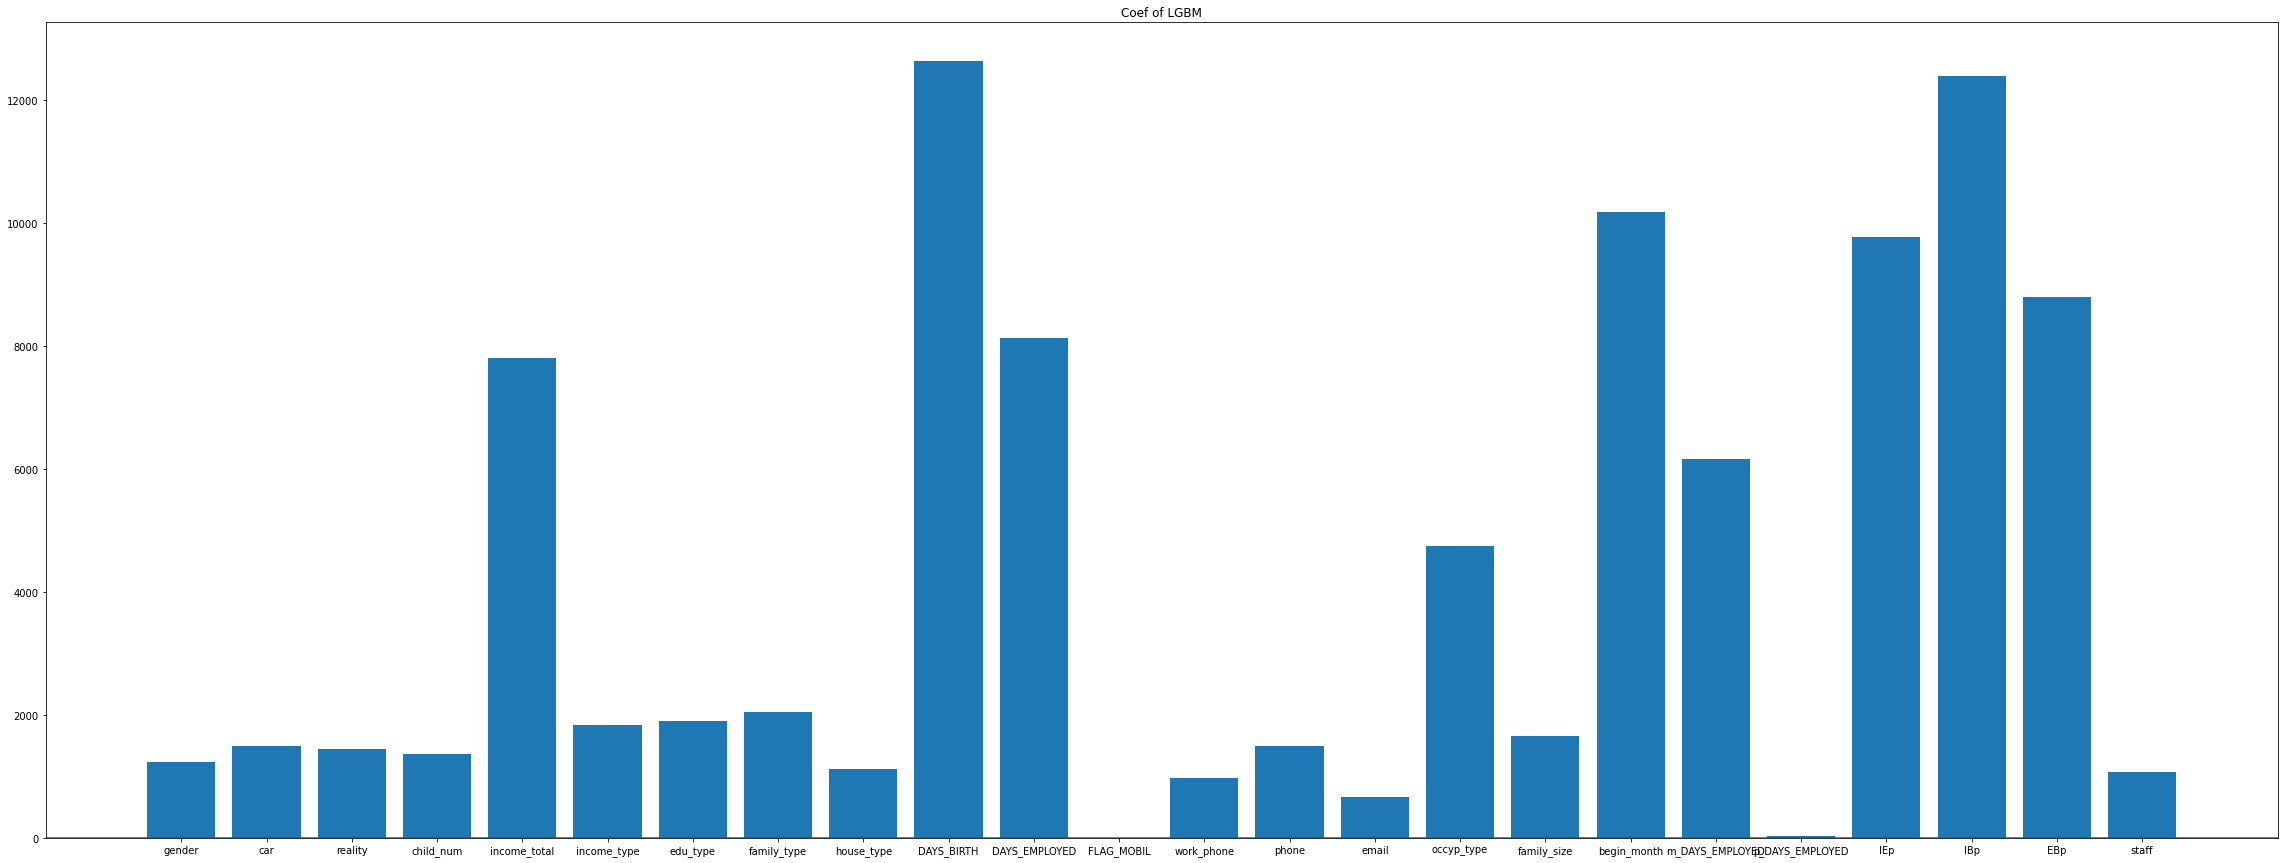

In [ ]:
figure, ax = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(40, 15)

# LGBM
ax.bar( X_train.columns,  lgbm.feature_importances_ )
ax.axhline(y=0, color='r', linestyle='-')
ax.set(title="Coef of LGBM")

In [ ]:
# 데이터 분할
from sklearn.model_selection import StratifiedKFold

# 모델
import lightgbm as LGBM

# 속도 체크
from tqdm import tqdm_notebook

# 성능 체크
from sklearn.metrics import log_loss

# CV는 20로
n_split = 10

# 균등하게 니눌때 사용
skf = StratifiedKFold(n_splits = n_split, shuffle=True, random_state=22)

# train 데이터에 대한 예측 값이 저장될 배열
lgbm_oof_train = np.zeros((y_train.shape[0], 3))

# test 데이터에 대한 예측 값이 저장될 배열
lgbm_oof_test = np.zeros((X_test.shape[0], 3))

# | iter      | target    | colsam... | learni... | max_depth | min_ch... | num_le... | subsample |

# |  4        | -0.7033   |  0.3202   |  0.009298 |  176.8    |  3.441    |  281.0    |  0.2846   |

# |  18       | -0.7026   |  0.323    |  0.009283 |  199.5    |  0.2399   |  250.9    |  0.2383   |

# |  16       | -0.7031   |  0.3495   |  0.009457 |  199.9    |  2.41     |  250.4    |  0.3816   |

# |  29       | -0.7028   |  0.331    |  0.00966  |  100.8    |  1.128    |  250.4    |  0.3803   |

param = {
    'random_state' : 22,
    'tree_method' : 'gpu_hist',
    'predictor' : 'gpu_predictor',
    'max_depth' : 200,
    'subsample' : 0.2383,
    'colsample_bytree' : 0.323,
    'learning_rate' : 0.009283,
    'n_estimators' : 100000,
    'min_child_weight' : 0.2399,
    'num_leaves' : 251
}

lgbm = LGBM.LGBMClassifier(**param)

result = []
pred_li = []
idx = 0

# oof 방식을 통한 예측
for trn_idx, val_idx in tqdm_notebook(skf.split(X_train, y_train)):
  trn_data, trn_label = X_train.iloc[trn_idx], y_train.iloc[trn_idx]
  val_data, val_label = X_train.iloc[val_idx], y_train.iloc[val_idx]

  # LGBM
  lgbm.fit(trn_data, trn_label, eval_set=(val_data, val_label), early_stopping_rounds = 500, verbose=-1)
  lgbm_valid_pred = lgbm.predict_proba(val_data)
  lgbm_oof_train[val_idx] = lgbm_valid_pred

  lgbm_test_pred = lgbm.predict_proba(X_test)
  lgbm_oof_test += lgbm_test_pred / n_split

  score = log_loss(val_label, lgbm_valid_pred)
  result.append(
      {"idx"   : idx,
       "val_score" : score}
  )
  pred_li.append(lgbm_test_pred)
  idx += 1

result = pd.DataFrame(result)
result

Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1205]	valid_0's multi_logloss: 0.686192
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1009]	valid_0's multi_logloss: 0.707644
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1099]	valid_0's multi_logloss: 0.693135
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1034]	valid_0's multi_logloss: 0.694445
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1104]	valid_0's multi_logloss: 0.691122
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1143]	valid_0's multi_logloss: 0.689186
Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[1145]	valid_0's multi_logloss: 0.697365
Training until validation s

,idx,val_score
0,0,0.686192
1,1,0.707644
2,2,0.693135
3,3,0.694445
4,4,0.691122
5,5,0.689186
6,6,0.697365
7,7,0.707118
8,8,0.674094
9,9,0.676263


In [ ]:
want_score = 0.68

In [ ]:
from sklearn.metrics import log_loss

test_submit_df = np.zeros((X_test.shape[0], 3))
idx_li = result[result['val_score'] <= want_score]['idx'].values.tolist()
for idx in idx_li:
  test_submit_df += pred_li[idx] / len(idx_li)

PATH = '/content/drive/MyDrive/DataAnalysis/신용카드 사용자 연체 예측 AI 경진대회/output/'

submission.iloc[:, 1:] = test_submit_df
submission.to_csv(PATH + '20210510_LGBM_best_675_7026.csv', index=False)
submission.head()

,index,0,1,2
0,26457,0.071098,0.093486,0.835417
1,26458,0.317169,0.299084,0.383747
2,26459,0.019907,0.040615,0.939478
3,26460,0.096983,0.094727,0.808290
4,26461,0.072903,0.180701,0.746396


In [ ]:
idx_li

[8, 9]

In [ ]:
from sklearn.metrics import log_loss

print("LGBMClassifier         :{} ".format( log_loss(y_train, lgbm_oof_train) ))

LGBMClassifier         :0.6916570204608654 


-0.7035을 받은 파라미터로 예측

LGBMClassifier         :0.6886720769846356 

-0.7033을 받은 파라미터로 예측

LGBMClassifier         :0.6878167640947502  <- CV20 (BEST)

LGBMClassifier         :0.6888785693357771  <- CV15

LGBMClassifier         :0.6916924979363376  <- CV10

LGBMClassifier         :0.7028037209342487  <- CV5

-0.7026을 받은 파라미터로 예측

LGBMClassifier         :0.6880603597724483  <- CV20, n_estimators 100000

LGBMClassifier         :0.6880603597724483  <- CV20, n_estimators 3000

-0.7028을 받은 파라미터로 예측

LGBMClassifier         :0.6881007361016515 

-0.7031을 받은 파라미터로 예측

LGBMClassifier         :0.6888130865891814 





In [ ]:
PATH = '/content/drive/MyDrive/DataAnalysis/신용카드 사용자 연체 예측 AI 경진대회/output/'

submission.iloc[:, 1:] = lgbm_oof_test
submission.to_csv(PATH + '20210510_LGBM_best_cv20_7033.csv', index=False)
submission.head()

,index,0,1,2
0,26457,0.082314,0.093130,0.824556
1,26458,0.273608,0.262231,0.464161
2,26459,0.026208,0.045226,0.928566
3,26460,0.099916,0.101425,0.798659
4,26461,0.082557,0.164451,0.752992
